# Xây dựng mô hình học máy và so sánh hiệu quả giữa chúng

In [1]:
%cd /content/drive/MyDrive/DS-DM-Project

/content/drive/MyDrive/DS-DM-Project


In [2]:
%pip install pyvi

## Import thư viện cần dùng

In [48]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import nltk
import gensim
from pyvi import ViUtils, ViTokenizer

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [4]:
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [5]:
warnings.filterwarnings('ignore')
sns.set(rc = {'figure.figsize':(15, 10)})

DATA_PATH = 'data/'
MODEL_PATH = 'model/'

## Phần I: Phân tích, tiền xử lý và xây dựng kịch bản thử nghiệm
Trong phần này, chúng ta sẽ tiến hành các bước để phân tích cơ bản về dữ liệu thu được và tiền xử lý chúng trước khi cho vào các mô hình học máy để tiến hành học

### Đọc các dữ liệu cần dùng

In [6]:
# read dantri.json file
dantri = pd.read_json(os.path.join(DATA_PATH, 'dantri.json'))

# read vietnamese stopwords
with open(os.path.join(DATA_PATH, 'vietnamese-stopwords.txt'), 'r') as f:
  stopwords = [line.rstrip("\n").strip().replace(' ', '_') for line in f]

In [7]:
# print first 5 object
dantri.head()

,title,category,content
0,"Thi hành án dứt điểm những vụ lớn, phức tạp li...",Xã hội,"Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng c..."
1,"Món quà của Thủ tướng dành cho những người ""kh...",Xã hội,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph..."
2,Thủ tướng thị sát đường sắt Nhổn - ga Hà Nội: ...,Xã hội,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph..."
3,Đại sứ Saudi Arabia: Mong muốn Việt Nam sớm vư...,Xã hội,Thủ tướng Phạm Minh Chính tiếp Đại sứ Saudi Ar...
4,"Tổng Thanh tra Chính phủ nói về giải pháp ""trị...",Xã hội,Tổng Thanh tra Chính phủ Đoàn Hồng Phong vừa c...


In [8]:
# print first 5 words in stopwords
stopwords[:5]

['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy']

### Phân tích và tiền xử lý

In [9]:
print(f"Dataset gồm {dantri.shape[0]} dữ liệu và {dantri.shape[1]} thuộc tính")

Dataset gồm 13931 dữ liệu và 3 thuộc tính


#### Remove NaN values

In [10]:
dantri.isna().sum()

title       0
category    0
content     0
dtype: int64

Dữ liệu trên không có giá trị nào NaN cả nên chúng ta không cần phải loại bỏ chúng

In [11]:
data = dantri[['content', 'category']]

Tổng có 15 hạng mục được thu về, tuy nhiên, có những bài báo rất ngắn vì nó chứa video, vì vậy chúng ta có thể chọn ra ngưỡng cho từng hạng mục để tránh việc bị Overfitting

#### Biểu đồ cột phân bố số lượng bài báo trên từng hạng mục

In [12]:
count = data["category"].value_counts()
num_of_post_each_topic = pd.DataFrame(
    {"category": count.index, "count": count.values}
)
num_of_post_each_topic

,category,count
0,Thể thao,1497
1,Giáo dục,1414
2,Sức khỏe,1270
3,Bất động sản,1229
4,Kinh doanh,1102
5,Văn hóa,1044
6,Xã hội,967
7,Xe ++,910
8,Sức mạnh số,800
9,Thế giới,759


In [13]:
fig = px.histogram(
    num_of_post_each_topic,
    x='category',
    y='count',
    color='category',
    title="Số lượng bài báo trên từng hạng mục",
    color_discrete_sequence=px.colors.qualitative.Set1,
)
fig.update_yaxes(showgrid=True)  # the y-axis is in dollars
fig.update_layout(  # customize font and legend orientation & position
    font_family="Arial",
    legend=dict(
        title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
    ),
    yaxis_title="Số lượng bài báo",
    xaxis_title="Hạng mục",
)

fig.add_shape(  # add a horizontal "target" line
    type="line",
    line_color="#16FF32",
    line_width=3,
    opacity=1,
    line_dash="dot",
    x0=0,
    x1=1,
    xref="paper",
    y0=929,
    y1=929,
    yref="y",
)

fig.add_annotation(  # add a text callout with arrow
    text="Số lượng ít nhất", x="Pháp luật", y=500, arrowhead=1, showarrow=True
)


fig.show()

Với biểu đồ cột ở trên, thấy rằng phân bố `số lượng bài báo` trên từng `hạng mục` là không đồng đều nhau. Điều này có nghĩa là khi chia ngẫu nhiên dữ liệu để xây dựng mô hình có thể xảy ra tình trạng **Imbalanced Data** vì số lượng bài báo của hạng mục đầu tiên trên trung bình mẫu (đường màu xanh) đã gấp hơn 2 lần so với số lượng bài báo thấp nhất (đường mũi tên).

Từ những nhận xét sơ cấp ở trên, chúng ta có thể xem xét đến hiệu suất của mô hình khi đã qua xử lý việc mất cân bằng dữ liệu

In [14]:
categories = data['category'].unique()
categories

array(['Xã hội', 'Việc làm', 'An sinh', 'Văn hóa', 'Thế giới',
       'Kinh doanh', 'Bất động sản', 'Sức mạnh số', 'Thể thao',
       'Sức khỏe', 'Giải trí', 'Giáo dục', 'Nhân ái', 'Xe ++',
       'Pháp luật'], dtype=object)

In [15]:
data['len'] = data['content'].str.len()
data.head()

,content,category,len
0,"Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng c...",Xã hội,2825
1,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,3688
2,"Sáng 12/2 (mùng 3 Tết Giáp Thìn), Thủ tướng Ph...",Xã hội,3759
3,Thủ tướng Phạm Minh Chính tiếp Đại sứ Saudi Ar...,Xã hội,5821
4,Tổng Thanh tra Chính phủ Đoàn Hồng Phong vừa c...,Xã hội,4660


In [16]:
def create_hist_plot(categories: list[str], df):
  fig, ax = plt.subplots(1, 3)
  for idx, category in enumerate(categories):
    df_category = df.query(f"`category` == '{category}'")
    sns.histplot(data=df_category, x="len", kde=True, ax=ax[idx])
    ax[idx].set_title(category)
  plt.show()



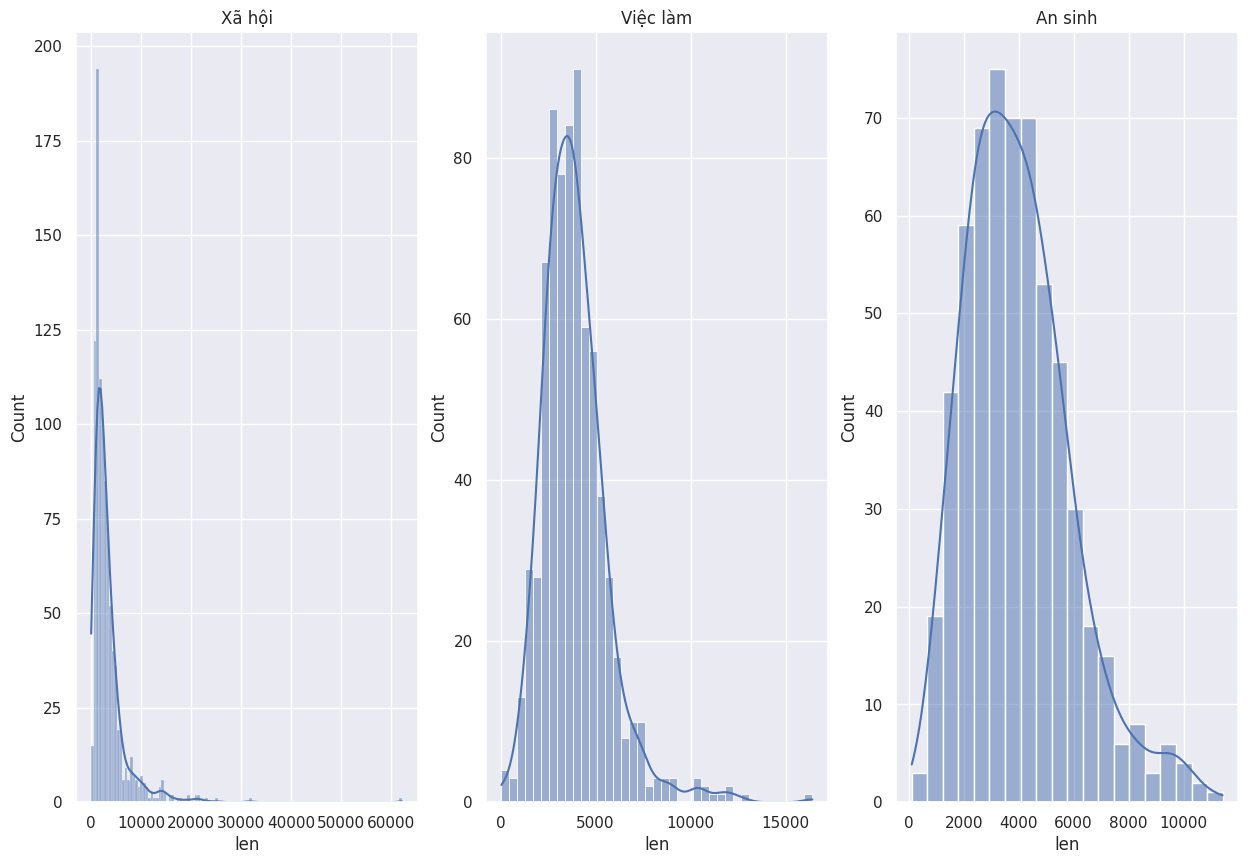

In [17]:
create_hist_plot(categories[:3], df=data)

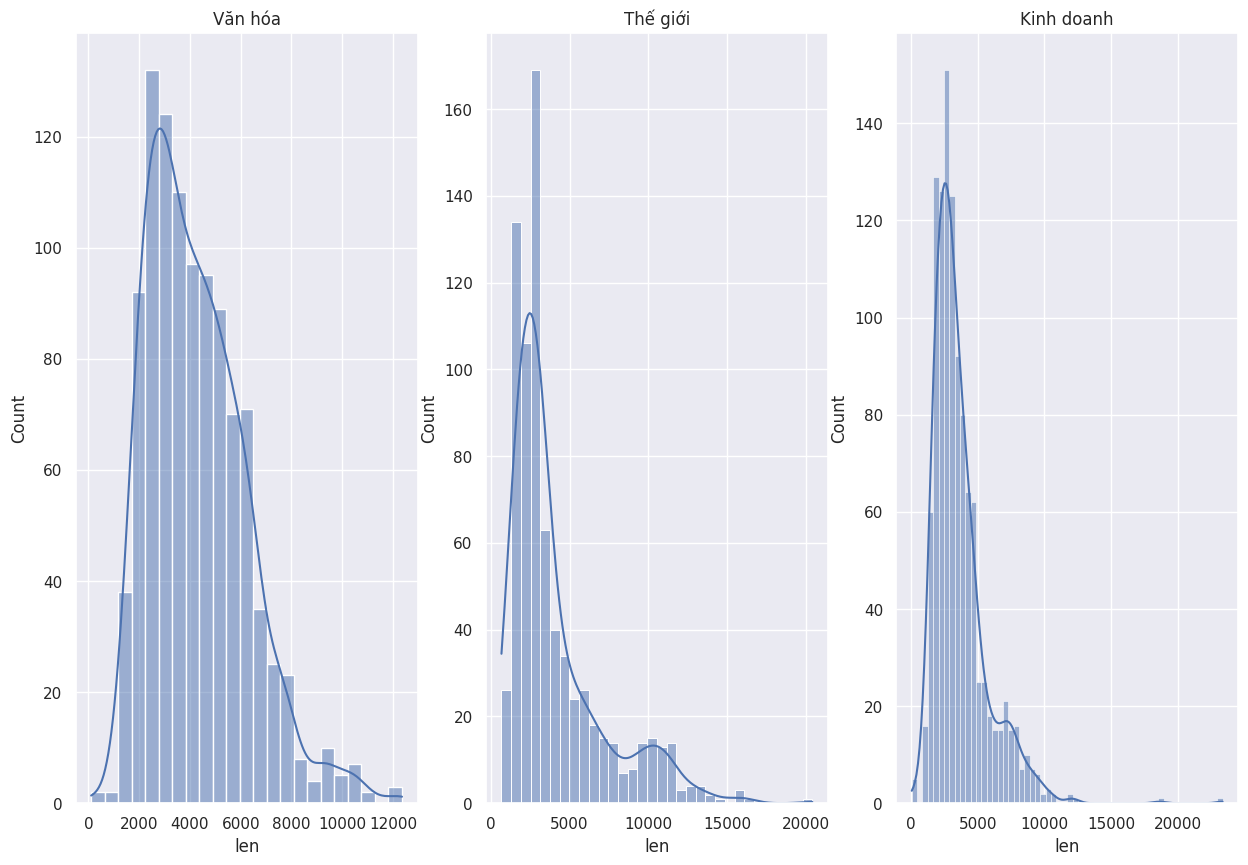

In [18]:
create_hist_plot(categories[3:6], df=data)


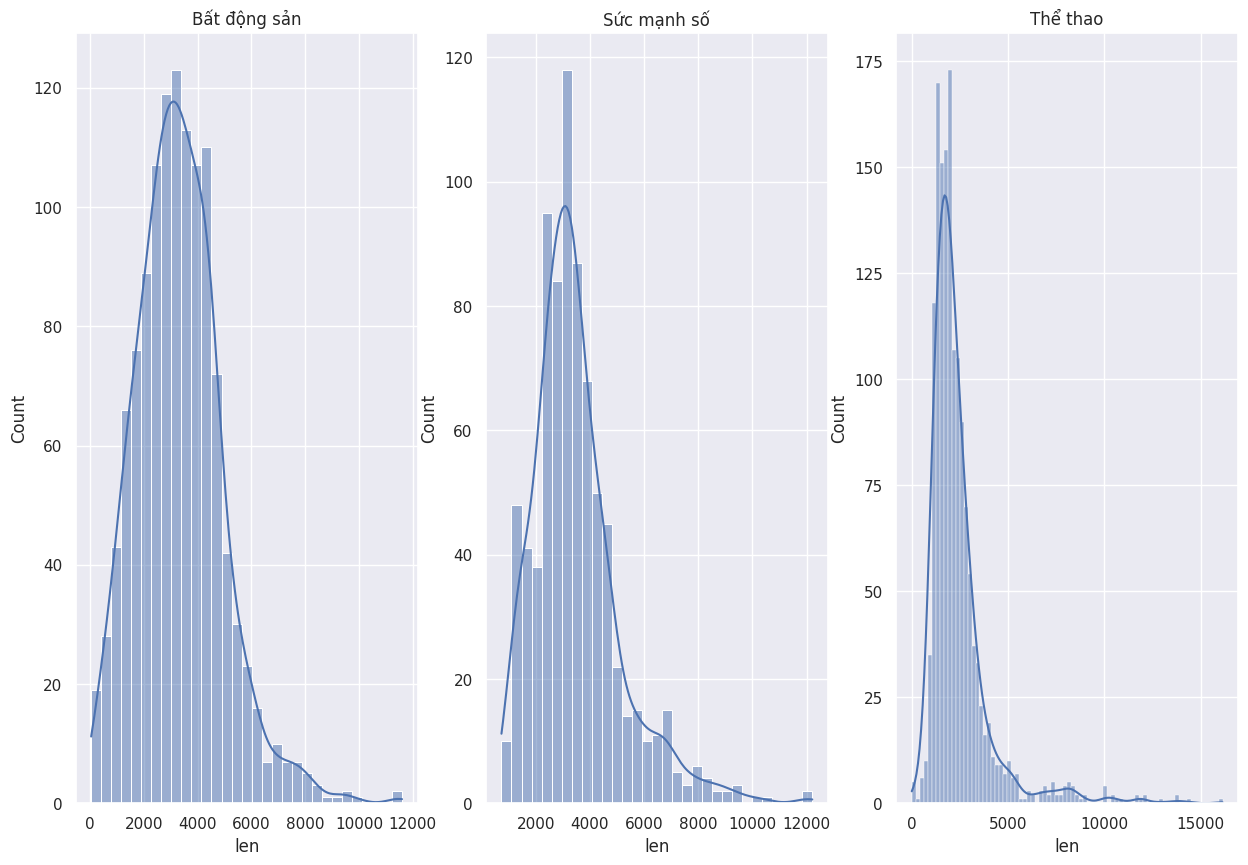

In [19]:
create_hist_plot(categories[6:9], df=data)


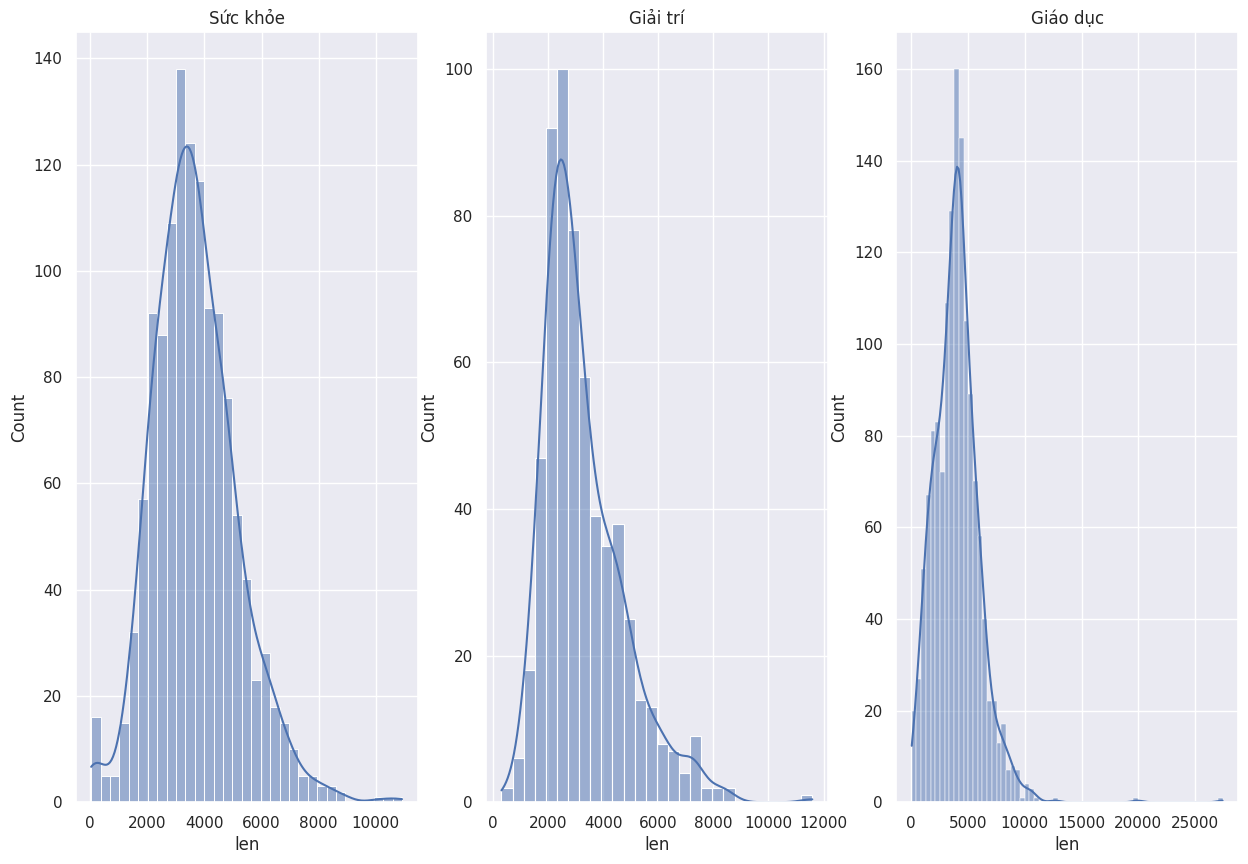

In [20]:
create_hist_plot(categories[9:12], df=data)


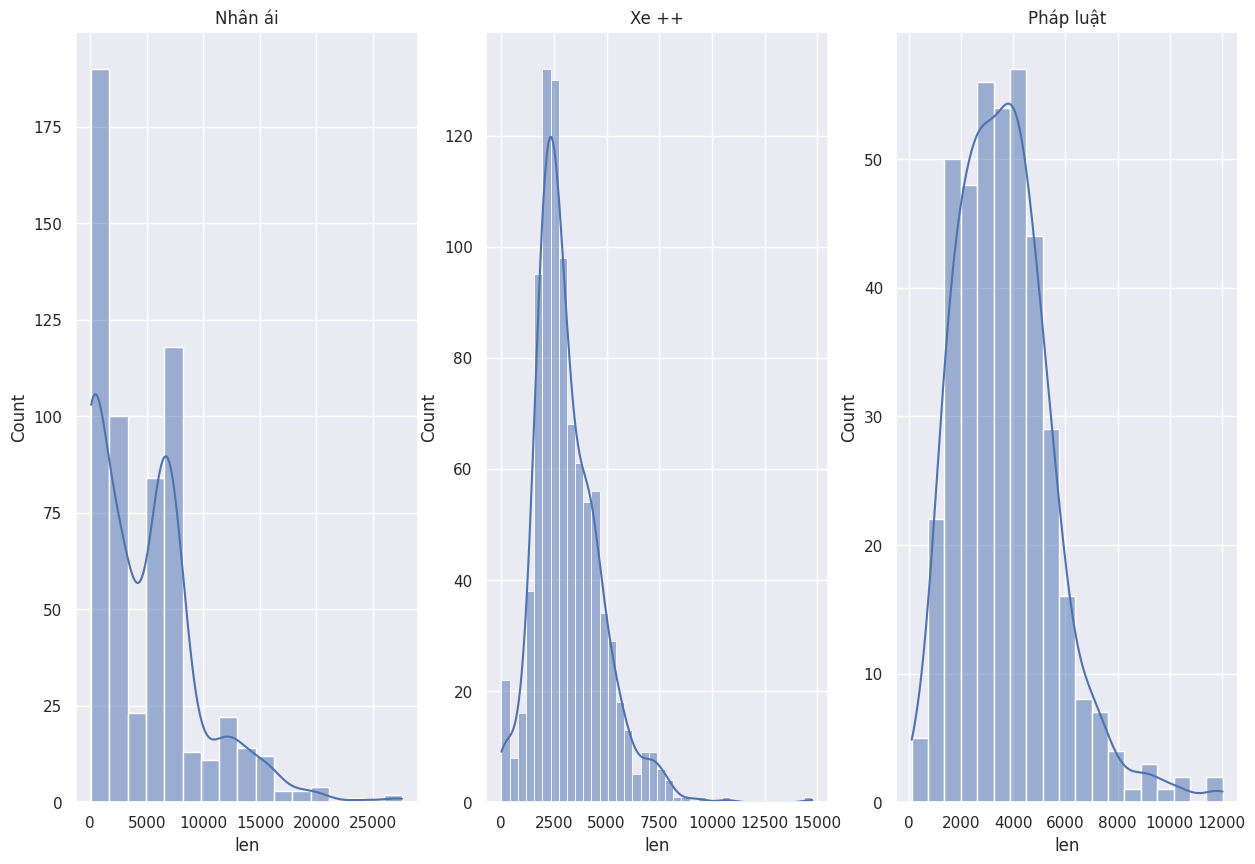

In [21]:
create_hist_plot(categories[12:15], df=data)


Nhận thấy rằng, hầu hết các hạng mục đều tuân theo dạng phân phối chuẩn (Gaussian) chỉ có duy nhất bài báo thuộc hạng mục `Nhân ái` không tuân theo dạng phân phối chuẩn.

Mặt khác, từ dữ liệu thực tế cho thấy rằng, các bài báo thuộc hạng mục `Nhân ái` thường là những bài báo có độ dài khá ngắn. Trong bin đầu tiên, nó chiếm khoảng 30% tổng só dữ liệu thuộc hạng mục Nhân ái

In [22]:
def create_box_plot(categories: list[str], df, method='linear'):
  df_category = df[df['category'].isin(categories)]
  fig = px.box(df_category, y="len", facet_col="category", color="category",
             boxmode="overlay")
  for col in range(1, 4):
    fig.update_traces(quartilemethod=method, jitter=0, col=col)
  fig.show()

In [23]:
create_box_plot(categories[12:15], df=data, method='exclusive')

Dựa vào khoảng tứ vị phân, ta chọn vị trí 25th, do đó sẽ chọn những bài bài có độ dài có độ dài >= 122

In [24]:
nhanai = data[data['category'] == 'Nhân ái']
data = data[data['category'] != 'Nhân ái']

In [25]:
nhanai = nhanai[nhanai['len'] >= 3734]

In [26]:
data = data.append(nhanai)
data.shape

(13631, 3)

In [27]:
count = data["category"].value_counts()
num_of_post_each_topic = pd.DataFrame(
    {"category": count.index, "count": count.values}
)
num_of_post_each_topic

fig = px.histogram(
    num_of_post_each_topic,
    x='category',
    y='count',
    color='category',
    title="Số lượng bài báo trên từng hạng mục",
    color_discrete_sequence=px.colors.qualitative.Set1,
)
fig.update_yaxes(showgrid=True)  # the y-axis is in dollars
fig.update_layout(  # customize font and legend orientation & position
    font_family="Arial",
    legend=dict(
        title=None, orientation="h", y=1, yanchor="bottom", x=0.5, xanchor="center"
    ),
    yaxis_title="Số lượng bài báo",
    xaxis_title="Hạng mục",
)

fig.add_shape(  # add a horizontal "target" line
    type="line",
    line_color="#16FF32",
    line_width=3,
    opacity=1,
    line_dash="dot",
    x0=0,
    x1=1,
    xref="paper",
    y0=929,
    y1=929,
    yref="y",
)

fig.add_annotation(  # add a text callout with arrow
    text="Số lượng ít nhất", x="Nhân ái", y=420, arrowhead=1, showarrow=True
)


fig.show()

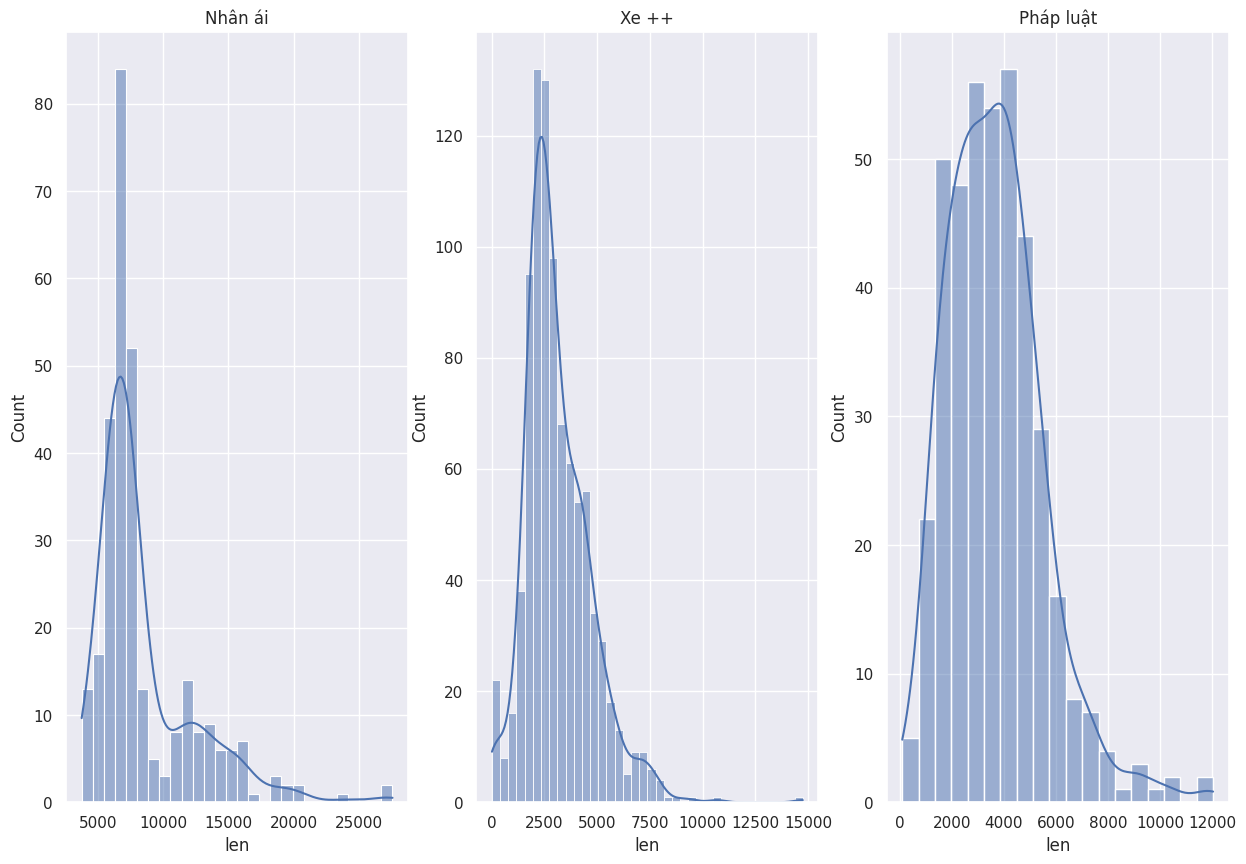

In [28]:
create_hist_plot(categories[12:15], data)

Ở phần này, chúng ta đã làm cho dữ liệu ở từng hạng mục gần dạng phân phối chuẩn

#### Text Cleaning
> Bình thường, trong tiếng Anh sẽ tách ra thành các từ đơn lẻ rồi chuyển sang dạng só thực một cách trực tiếp. Tuy nhiên, trong tiếng Việt sẽ có những từ phải đi cùng một cặp với nhau thì sẽ mang ý nghĩa rõ ràng hơn. Do đó cách xử lý sẽ khác so với tiếng Anh

In [32]:
class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self) -> None:
        super().__init__()

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        cleaned_texts = []
        for text in X:
            cleaned_text = self.clean_text(text)
            cleaned_texts.append(cleaned_text)
        return np.array(cleaned_texts)

    @staticmethod
    def clean_text(content: str):
        # Text Normalizer
        # lowercase content
        # content = content.lower()
        # # remove white space
        # content = " ".join([x for x in content.split()])
        # # remove punctuation and digits
        # content = content.translate(str.maketrans("", "", punc_custom)).translate(
        #     str.maketrans("", "", digits)
        # )

        # Sử dụng `gensim` để xử lý cơ bản text
        tokens = gensim.utils.simple_preprocess(content)
        content = " ".join(tokens)
        # tokenize content
        content = ViTokenizer.tokenize(content)

        return content

In [33]:
X, label = data['content'].values, data['category'].values

print(X.shape, label.shape)

(13631,) (13631,)


In [35]:
print(X[:2])
print(label[:2])

['Ông Nguyễn Văn Sơn, Phó Tổng cục trưởng Tổng cục Thi hành án dân sự (Bộ Tư pháp) vừa ký ban hành kế hoạch công tác năm 2024 của Tổ công tác chỉ đạo xử lý các vụ việc liên quan đến hoạt động tín dụng, ngân hàng (Tổ xử lý nợ xấu). Tổ xử lý nợ xấu có trách nhiệm phối hợp với Vụ Pháp chế (Ngân hàng Nhà nước), Hiệp hội Ngân hàng tổ chức tọa đàm, đối thoại giữa các cơ quan thi hành án với tổ chức tín dụng, Công ty quản lý tài sản (VAMC) để trao đổi, tháo gỡ khó khăn, vướng mắc liên quan đến các vụ việc thi hành án tín dụng, ngân hàng. Trong đó, tập trung rà soát, tổng hợp các vụ việc trên cơ sở thông báo kết luận kiểm tra các năm 2022, 2023 hoặc đề nghị của Hiệp hội Ngân hàng, các tổ chức tín dụng, VAMC. "Phối hợp chỉ đạo tổ chức thi hành dứt điểm đối với những vụ việc có điều kiện, nhất là những đơn vị có nhiều vụ việc lớn, phức tạp liên quan đến các tổ chức tín dụng như Agribank, Vietcombank, VPBank, BIDV, Vietinbank", lãnh đạo Tổng cục Thi hành án dân sự nêu rõ. Ông Nguyễn Văn Sơn, Phó 

In [37]:
le = LabelEncoder()
y = le.fit_transform(label)

print(le.classes_)

['An sinh' 'Bất động sản' 'Giáo dục' 'Giải trí' 'Kinh doanh' 'Nhân ái'
 'Pháp luật' 'Sức khỏe' 'Sức mạnh số' 'Thế giới' 'Thể thao' 'Việc làm'
 'Văn hóa' 'Xe ++' 'Xã hội']


### Kịch bản thử nghiệm

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Xây dựng tệp từ điển

In [42]:
# No Cleaner
count_vectorizer_no_cleaner = CountVectorizer(stop_words=stopwords)
count_vectorizer_no_cleaner.fit(X_train)
MAX_FEATURES = len(count_vectorizer_no_cleaner.vocabulary_)

# With Cleaner
text_cleaner = TextCleaner()
count_vectorizer_with_cleaner = CountVectorizer(stop_words=stopwords)
X_train_with_cleaner = text_cleaner.fit_transform(X_train)
count_vectorizer_with_cleaner.fit(X_train_with_cleaner)
MAX_FEATURES_WITH_CLEANER = len(count_vectorizer_with_cleaner.vocabulary_)

In [43]:
MAX_FEATURES, MAX_FEATURES_WITH_CLEANER

(41402, 59439)

In [44]:
def create_pipeline(stop_words, cleaner=False, percentage=0.8):
  steps = []
  count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=int(percentage * MAX_FEATURES))
  if cleaner:
    text_cleaner = TextCleaner()
    count_vectorizer = CountVectorizer(stop_words=stop_words, max_features=int(percentage * MAX_FEATURES_WITH_CLEANER))
    steps.append(('cleaner', text_cleaner))

  # Add steps to convert text to matrix
  steps.append(('count_vectorizer', count_vectorizer))
  steps.append(('tfidf_transformer', TfidfTransformer()))

  return Pipeline(steps)



#### Kịch bản 1: Xử lý dữ liệu có TextCleaner

In [45]:
pipeline_cleaner = create_pipeline(stopwords, cleaner=True)
X_train_cleaner_processed = pipeline_cleaner.fit_transform(X_train)

In [47]:
svc = SVC(kernel='linear', C=1.0)
svc.fit(X_train_cleaner_processed, y_train)

SVC(kernel='linear')

In [49]:
X_test_cleaner_processed = pipeline_cleaner.transform(X_test)

In [50]:
y_pred = svc.predict(X_test_cleaner_processed)
print("- Acc = {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=le.classes_))

- Acc = 0.9017235056839017
              precision    recall  f1-score   support

     An sinh       0.77      0.74      0.75       102
Bất động sản       0.93      0.93      0.93       268
    Giáo dục       0.92      0.93      0.92       278
    Giải trí       0.77      0.81      0.79       118
  Kinh doanh       0.81      0.85      0.83       206
     Nhân ái       1.00      0.97      0.99        71
   Pháp luật       0.92      0.95      0.94        88
    Sức khỏe       0.97      0.96      0.96       260
 Sức mạnh số       0.94      0.94      0.94       161
    Thế giới       0.96      0.84      0.89       155
    Thể thao       0.98      0.98      0.98       289
    Việc làm       0.83      0.79      0.81       139
     Văn hóa       0.88      0.88      0.88       211
       Xe ++       0.93      0.97      0.95       174
      Xã hội       0.85      0.85      0.85       207

    accuracy                           0.90      2727
   macro avg       0.90      0.89      0.89      2727

In [52]:
mul_nb = MultinomialNB()
mul_nb.fit(X_train_cleaner_processed, y_train)
y_pred = mul_nb.predict(X_test_cleaner_processed)
print("- Acc = {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=le.classes_))

- Acc = 0.8104143747708105
              precision    recall  f1-score   support

     An sinh       0.90      0.27      0.42       102
Bất động sản       0.79      0.94      0.86       268
    Giáo dục       0.60      0.99      0.75       278
    Giải trí       0.92      0.38      0.54       118
  Kinh doanh       0.74      0.81      0.77       206
     Nhân ái       1.00      0.94      0.97        71
   Pháp luật       0.96      0.59      0.73        88
    Sức khỏe       0.94      0.96      0.95       260
 Sức mạnh số       0.95      0.74      0.83       161
    Thế giới       0.97      0.59      0.74       155
    Thể thao       0.96      0.97      0.96       289
    Việc làm       0.81      0.46      0.59       139
     Văn hóa       0.69      0.86      0.76       211
       Xe ++       0.94      0.97      0.95       174
      Xã hội       0.76      0.82      0.79       207

    accuracy                           0.81      2727
   macro avg       0.86      0.75      0.77      2727

In [53]:
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train_cleaner_processed, y_train)
y_pred = rf.predict(X_test_cleaner_processed)
print("- Acc = {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=le.classes_))

- Acc = 0.8723872387238724
              precision    recall  f1-score   support

     An sinh       0.85      0.49      0.62       102
Bất động sản       0.87      0.93      0.90       268
    Giáo dục       0.82      0.98      0.89       278
    Giải trí       0.88      0.70      0.78       118
  Kinh doanh       0.78      0.84      0.81       206
     Nhân ái       1.00      0.96      0.98        71
   Pháp luật       0.93      0.94      0.94        88
    Sức khỏe       0.91      0.97      0.94       260
 Sức mạnh số       0.92      0.83      0.87       161
    Thế giới       0.96      0.74      0.83       155
    Thể thao       0.95      0.96      0.95       289
    Việc làm       0.82      0.71      0.76       139
     Văn hóa       0.82      0.90      0.86       211
       Xe ++       0.92      0.97      0.95       174
      Xã hội       0.81      0.79      0.80       207

    accuracy                           0.87      2727
   macro avg       0.88      0.85      0.86      2727

In [54]:
sgd = SGDClassifier()
sgd.fit(X_train_cleaner_processed, y_train)
y_pred = sgd.predict(X_test_cleaner_processed)
print("- Acc = {}".format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, target_names=le.classes_))

- Acc = 0.903923725705904
              precision    recall  f1-score   support

     An sinh       0.84      0.67      0.74       102
Bất động sản       0.93      0.93      0.93       268
    Giáo dục       0.91      0.95      0.93       278
    Giải trí       0.77      0.86      0.81       118
  Kinh doanh       0.83      0.83      0.83       206
     Nhân ái       1.00      0.97      0.99        71
   Pháp luật       0.92      0.99      0.95        88
    Sức khỏe       0.96      0.98      0.97       260
 Sức mạnh số       0.94      0.93      0.93       161
    Thế giới       0.97      0.82      0.89       155
    Thể thao       0.97      0.98      0.97       289
    Việc làm       0.83      0.79      0.81       139
     Văn hóa       0.86      0.88      0.87       211
       Xe ++       0.93      0.98      0.96       174
      Xã hội       0.85      0.85      0.85       207

    accuracy                           0.90      2727
   macro avg       0.90      0.89      0.90      2727


#### Kịch bản 2: Xử lý dữ liệu không có TextCleaner